In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd


from hcnn.model import HarmonicFeatureExtractor, HarmonicFeatureExtractorConfig
from hcnn.utils import visualize_features
from data.kaggle_dataset.kaggle_raga_dataset import KaggleRagaDataset
from data.kaggle_dataset.kaggle_raga_dataloader import KaggleRagaDataloader

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
config = HarmonicFeatureExtractorConfig()
config.sample_rate = 44100
config.n_fft = 4096
config.hop_length = 2048
config.n_harmonics = 2
config.n_filters_per_semitone = 24
fe = HarmonicFeatureExtractor(config=config)

In [15]:
seq_len_s = 30
sample_rate = 44100
ds = KaggleRagaDataset('./data/kaggle_dataset/2', seq_len_s, sample_rate)

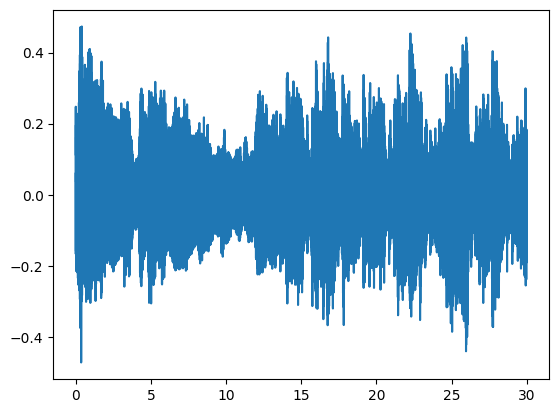

In [16]:
x, label = ds[12]
plt.plot(np.linspace(0, x.shape[1]/sample_rate, x.shape[1]), x.flatten())
ipd.Audio(x, rate=ds.sample_rate)

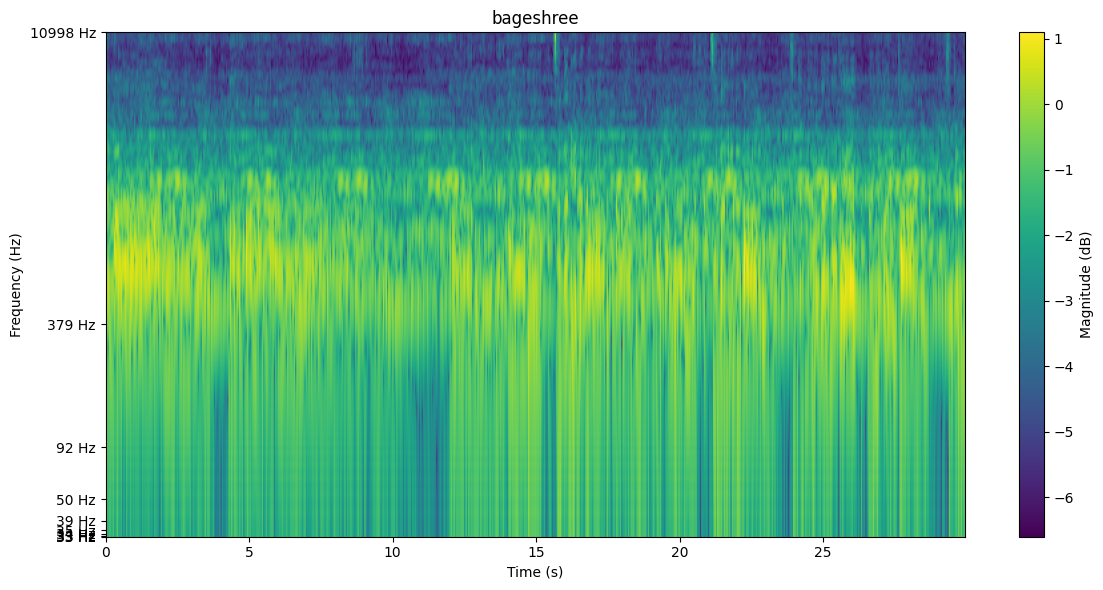

In [17]:
features = fe(x).detach()
visualize_features(features, sample_rate=config.sample_rate, hop_length=config.hop_length, center_freqs=fe.center_freqs,
                   title=f'{ds.get_label_name(label)}', figsize=(12, 6))